In [2]:
##### Setup feedback system
# from learntools.core import binder
# binder.bind(globals())
# from learntools.time_series.ex5 import *

# Setup notebook
from pathlib import Path
# from learntools.time_series.style import *  # plot style settings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


store_sales = pd.read_csv(
    './csv/store sales/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [3]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method


In [4]:
def fit(self, X_1, X_2, y):
    self.model_1.fit(X_1, y)

    y_fit = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    y_resid = y-y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit


In [6]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Add method to class
BoostedHybrid.predict = predict


In [7]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

### LinearRegression + XGBoost Train

In [8]:
model = BoostedHybrid(
model_1= LinearRegression(fit_intercept=False),
model_2= XGBRegressor()
)

# YOUR CODE HERE: Fit and predict
model.fit(X_1, X_2,y)
y_pred = model.predict(X_1, X_2)

y_pred = y_pred.clip(0.0)

In [10]:
# 다른 모델 활용하기
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# YOUR CODE HERE: Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

C:\Users\sunk2\anaconda3\envs\kaggle\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


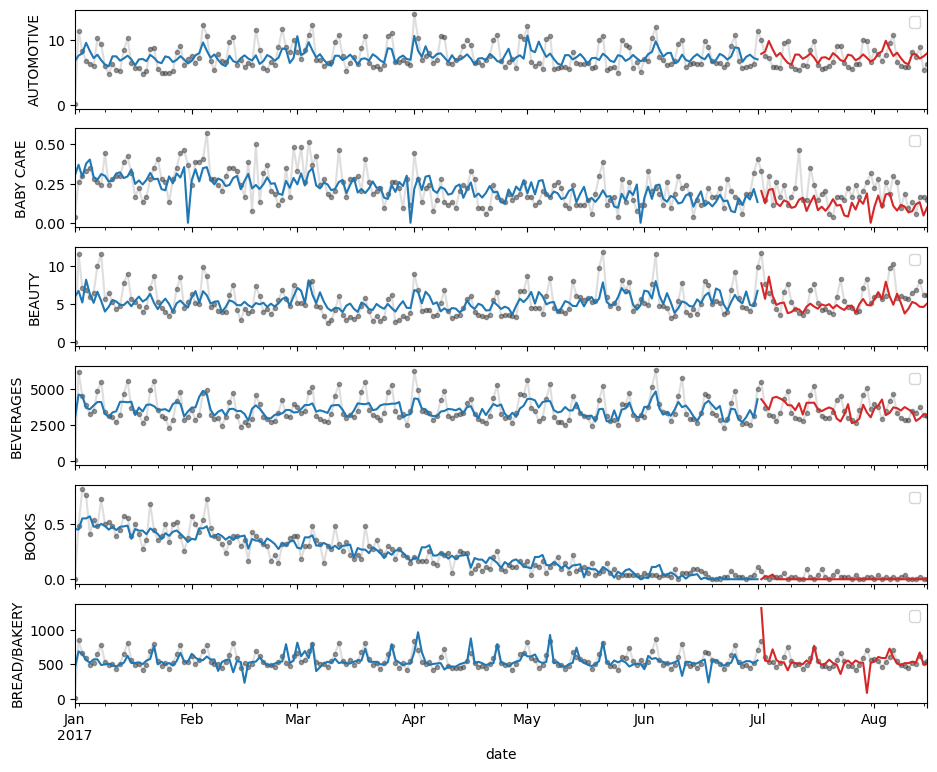

In [13]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)


y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)